In [1]:
import cell2cell as c2c
import scanpy as sc
import pandas as pd

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import gseapy

import liana as li
import plotnine as p9
import os
%matplotlib inline

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

In [3]:
torch.cuda.is_available()

False

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable



def generate_dot_plot(pval_df, score_df, significance=0.05, xlabel='', ylabel='', cbar_title='Score', cmap='PuOr',
                      figsize=(16, 9), label_size=20, title_size=20, tick_size=14, filename=None):
    '''Generates a dot plot for given P-values and respective scores.
    Parameters
    ----------
    pval_df : pandas.DataFrame
        A dataframe containing the P-values, with multiple elements
        in both rows and columns
    score_df : pandas.DataFrame
        A dataframe containing the scores that were tested. Rows and
        columns must be the same as in `pval_df`.
    significance : float, default=0.05
        The significance threshold to be plotted. LR pairs or cell-cell
        pairs with at least one P-value below this threshold will be
        considered.
    xlabel : str, default=''
        Name or label of the X axis.
    ylabel : str, default=''
        Name or label of the Y axis.
    cbar_title : str, default='Score'
        A title for the colorbar associated with the scores in
        `score_df`. It is usually the name of the score.
    cmap : str, default='PuOr'
        A matplotlib color palette name.
    figsize : tuple, default=(16, 9)
        Size of the figure (width*height), each in inches.
    label_size : int, default=20
        Specifies the size of the labels of both X and Y axes.
    title_size : int, default=20
        Specifies the size of the title of the colorbar and P-val sizes.
    tick_size : int, default=14
        Specifies the size of ticklabels as well as the maximum size
        of the dots.
    filename : str, default=None
        Path to save the figure of the elbow analysis. If None, the figure is not
        saved.
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object made with matplotlib
    '''
    # Reorder the dataframes according to the custom pathway order
    # Preprocessing
    df = pval_df.lt(significance).astype(int)
    # Drop all zeros
    df = df.loc[(df != 0).any(axis=1)]
    df = df.T.loc[(df != 0).any(axis=0)].T
    pval_df = pval_df[df.columns].loc[df.index].applymap(lambda x: -1. * np.log10(x + 1e-9))

    # Set dot sizes and color range
    max_abs = np.max([np.abs(np.min(np.min(score_df))), np.abs(np.max(np.max(score_df)))])
    norm = mpl.colors.Normalize(vmin=-1. * max_abs, vmax=max_abs)
    max_size = mpl.colors.Normalize(vmin=0, vmax=9)

    # Colormap
    cmap = mpl.cm.get_cmap(cmap)

    # Dot plot
    #mpl.style.use('seaborn-white')
    fig, (ax2, ax) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 9]})
    for i, idx in enumerate(pval_df.index):
        for j, col in enumerate(pval_df.columns):
            color = np.asarray(cmap(norm(score_df[[col]].loc[[idx]].values.item()))).reshape(1, -1)
            size = (max_size(pval_df[[col]].loc[[idx]].values.max()) * tick_size * 2) ** 2
            ax.scatter(j, i, s=size, c=color)


    # Change tick labels
    xlabels = list(pval_df.columns)
    ylabels = list(pval_df.index)
    ax.grid(True)
    ax.set_xticks(ticks=range(0, len(pval_df.columns)))
    ax.set_xticklabels(xlabels,
                       fontsize=tick_size,
                       rotation=90,
                       rotation_mode='anchor',
                       va='center',
                       ha='right')

    ax.set_yticks(ticks=range(0, len(pval_df.index)))
    ax.set_yticklabels(ylabels,
                       fontsize=tick_size,
                       rotation=0, ha='right', va='center'
                       )

    plt.gca().invert_yaxis()

    plt.tick_params(axis='both',
                    which='both',
                    bottom=True,
                    top=False,
                    right=False,
                    left=True,
                    labelleft=True,
                    labelbottom=True)
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)

    # Colorbar
    # create an axes on the top side of ax. The width of cax will be 3%
    # of ax and the padding between cax and ax will be fixed at 0.21 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="3%", pad=0.21)

    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax,
                        orientation='horizontal'
                        )
    cbar.ax.tick_params(labelsize=tick_size)

    cax.tick_params(axis='x',  # changes apply to the x-axis
                    which='both',  # both major and minor ticks are affected
                    bottom=False,  # ticks along the bottom edge are off
                    top=True,  # ticks along the top edge are off
                    labelbottom=False,  # labels along the bottom edge are off
                    labeltop=True
                    )
    cax.set_title(cbar_title, fontsize=title_size)

    for i, v in enumerate([np.min(np.min(pval_df)), -1. * np.log10(significance + 1e-9), 3.0]):
        ax2.scatter(i, 0, s=(max_size(v) * tick_size * 2) ** 2, c='k')
        ax2.scatter(i, 1, s=0, c='k')
        if v == 3.0:
            extra = '>='
        elif i == 1:
            extra = 'Threshold: '
        else:
            extra = ''
        ax2.annotate(extra + str(np.round(abs(v), 4)), (i, 1), fontsize=tick_size, horizontalalignment='center')
    ax2.set_ylim(-0.5, 2)
    ax2.axis('off')
    ax2.set_title('-log10(P-value) sizes', fontsize=title_size)
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    return 

In [7]:
use_gpu = True

In [4]:
if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

In [5]:
import torch

In [6]:
torch.cuda.is_available()

True

In [ ]:
c2c.__version__

0.6.8

In [23]:
adata_st = sc.read_h5ad("../../spatial_processed.h5ad")

In [24]:
adata_st

AnnData object with n_obs × n_vars = 8149 × 17628
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'clusters', 'clusters_0.7', 'cell_type_base', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_types_colors', 'clusters_0.7_colors', 'hvg', 'leiden', 'library_id_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'LogNorm', 'scaled'
    obsp: 'connectivities', 'distances'

In [3]:
expr_threshold = 0.85

In [25]:
pathway_per_gene = c2c.external.load_gmt("/exports/humgen/cnovellarausell/SevtapSpatial/gmts/wikipathways.gmt")

In [26]:
lr_pairs = li.resource.select_resource('MouseConsensus')
lr_pairs.head()

ligand     receptor
31371   Dll1       Notch1
31372   Dll1       Notch2
31373   Dll1       Notch4
31374   Dll1       Notch3
31375   Nrg2  Erbb2_Erbb3

In [27]:
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()]

In [28]:
organism = 'mouse' # For the COVID-19 data analyzed with LIANA+Tensor-cell2cell
pathwaydb = 'GOBP' # KEGG Pathways

In [29]:
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep='_',
                                          lr_sep='^',
                                          organism=organism,
                                          pathwaydb=pathwaydb,
                                          readable_name=True,
                                          pathway_per_gene=pathway_per_gene,
                                          )

# Adata processing

In [30]:
adata_st.obs['Cell_type'] = adata_st.obs['cell_types']

In [31]:
adata_st.obs['Cell_type'].value_counts()

PTS1/2            2017
PTS3              1052
FR-PT + Immune    1005
Inj PT             871
TAL                726
DCT-CNT            689
CD-IC              677
PTS3T2             350
CD-PC              336
Podo               279
Immune              88
Fib                 59
Name: Cell_type, dtype: int64

In [32]:
S2 = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/Notebooks/cystic_spots/S2_realign_layers_exclUnlabeled.csv", skiprows=1, index_col=0, names=['barcode', 'layer'] )
S3 = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/Notebooks/cystic_spots/S3_realign_layers_exclUnlabeled.csv", skiprows=1, index_col=0, names=['barcode', 'layer'] )
S4 = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/Notebooks/cystic_spots/S4_realign_layers_exclUnlabeled.csv", skiprows=1, index_col=0, names=['barcode', 'layer'] )

In [33]:
S2['layer'] = S2.layer.str.split('_').str[2]
S3['layer'] = S3.layer.str.split('_').str[2]
S4['layer'] = S4.layer.str.split('_').str[2]

In [34]:
S2.index = S2.index.str.split('-').str[0] + '-1-pkd_1'
S3.index = S3.index.str.split('-').str[0] + '-1-pkd_2'
S4.index = S4.index.str.split('-').str[0] + '-1-pkd_3'

In [35]:
layers = pd.concat([S2,S3,S4])

In [36]:
layers

layer
barcode                         
AAACAGAGCGACTCCT-1-pkd_1  layer1
AAACTCGGTTCGCAAT-1-pkd_1  layer2
AAAGTAGCATTGCTCA-1-pkd_1  layer1
AAATAGCTTAGACTTT-1-pkd_1  layer3
AAATCCGATACACGCC-1-pkd_1  layer1
...                          ...
TTGTGGTAGGAGGGAT-1-pkd_3  layer2
TTGTGTATGCCACCAA-1-pkd_3  layer1
TTGTGTTTCCCGAAAG-1-pkd_3  layer3
TTGTTAGCAAATTCGA-1-pkd_3  layer2
TTGTTTCACATCCAGG-1-pkd_3  layer2

[2650 rows x 1 columns]

In [37]:
adata_st.obs['layers'] = layers

In [38]:
adata_st.obs['layers'].value_counts()

layer1       916
layer2       755
layer3       547
noncystic    347
Name: layers, dtype: int64

In [39]:
adata_st = adata_st[adata_st.obs['layers'].isin(['layer1', 'layer2', 'layer3', 'noncystic'])].copy()

... storing 'layers' as categorical
... storing 'layers' as categorical
... storing 'layers' as categorical


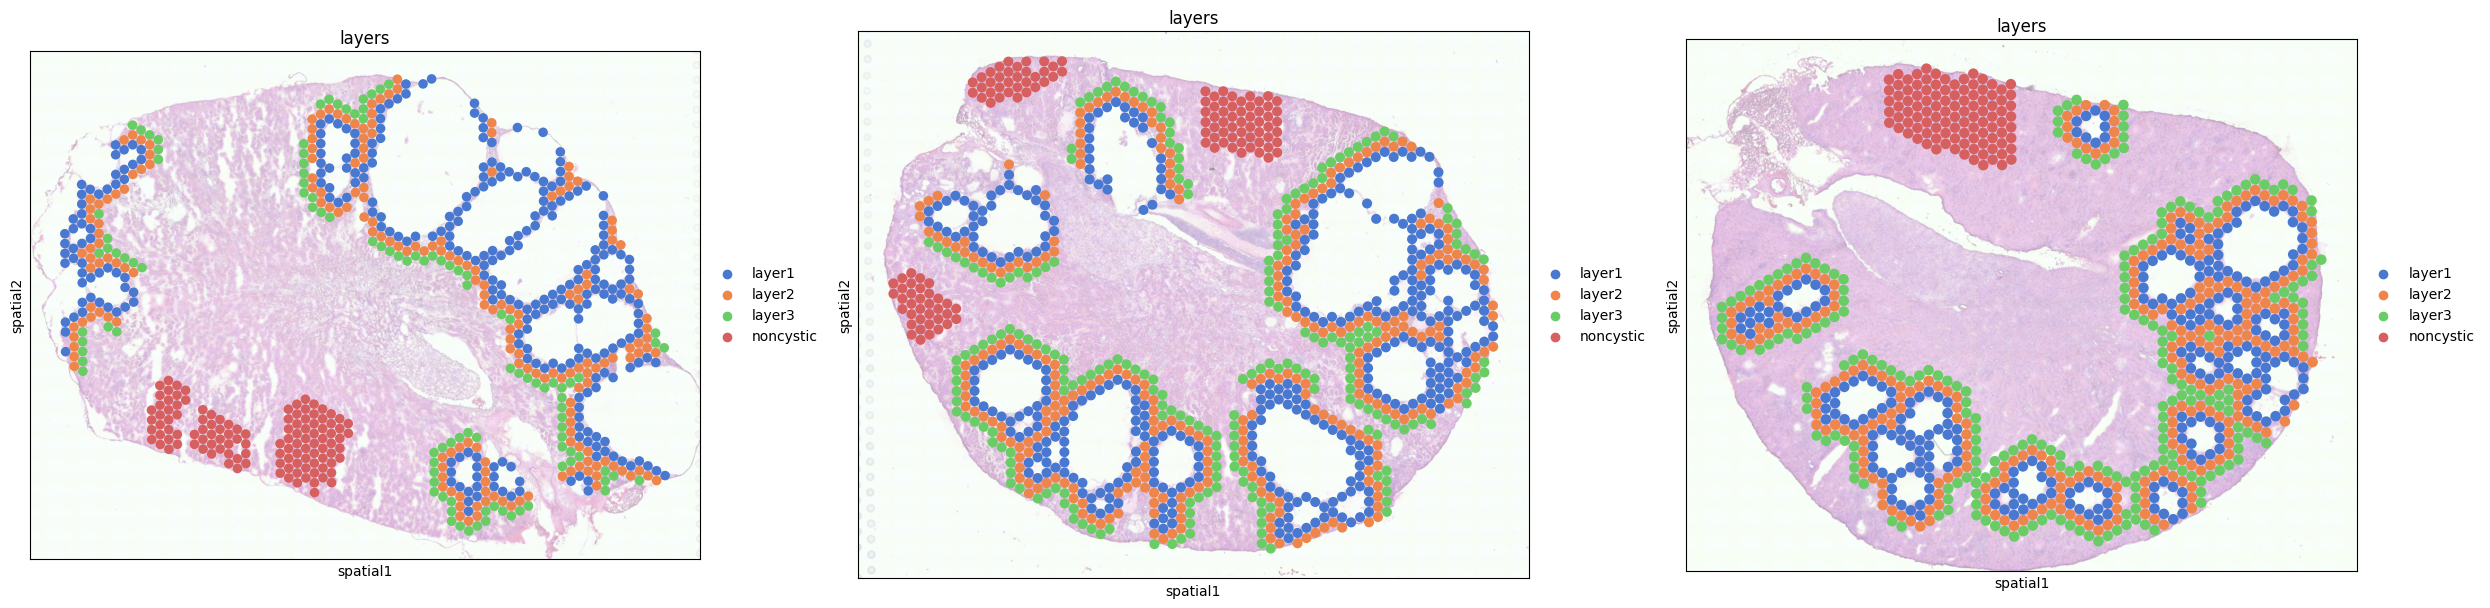

In [37]:
fig, axs = plt.subplots(1,3, figsize=(25, 10))

for i, library in enumerate(
    ["pkd_1", "pkd_2", "pkd_3"]
):
    ad = adata_st[adata_st.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color=["layers"],
        size=1.5,
        alpha_img=0.5,
        palette=sns.color_palette("muted"),
        show=False,
        ax=axs[i]
    )
plt.tight_layout()
plt.savefig('spatial_layers_3_kidneys.pdf')

In [40]:
adata_layers = adata_st[adata_st.obs['layers'].isin(['layer1', 'layer2', 'layer3'])].copy()

In [41]:
pkd_1_segmentation_dc_new = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_1_v1/pkd_1_tangram_ct_count_denoised_ZimmermanHumphreysMuto.csv", index_col=0 )
pkd_2_segmentation_dc_new = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_2_v1/pkd_2_tangram_ct_count_denoised_ZimmermanHumphreysMuto.csv", index_col=0 )
pkd_3_segmentation_dc_new = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_3_v1/pkd_3_tangram_ct_count_denoised_ZimmermanHumphreysMuto.csv", index_col=0 )

In [42]:
pkd_1_macro_series = pkd_1_segmentation_dc_new['Macro'] + pkd_1_segmentation_dc_new['Lyc6 high Macrophages'] + pkd_1_segmentation_dc_new['Lyc6 low Macrophages'] \
    + pkd_1_segmentation_dc_new['Mrc1+ Resident Macrophages'] + pkd_1_segmentation_dc_new['Spp1+ Resident Macrophages ']
pkd_2_macro_series = pkd_2_segmentation_dc_new['Macro'] + pkd_2_segmentation_dc_new['Lyc6 high Macrophages'] + pkd_2_segmentation_dc_new['Lyc6 low Macrophages'] \
    + pkd_2_segmentation_dc_new['Mrc1+ Resident Macrophages'] + pkd_2_segmentation_dc_new['Spp1+ Resident Macrophages ']
pkd_3_macro_series = pkd_3_segmentation_dc_new['Macro'] + pkd_3_segmentation_dc_new['Lyc6 high Macrophages'] + pkd_3_segmentation_dc_new['Lyc6 low Macrophages'] \
    + pkd_3_segmentation_dc_new['Mrc1+ Resident Macrophages'] + pkd_3_segmentation_dc_new['Spp1+ Resident Macrophages ']

In [43]:
pkd_1_nk_series = pkd_1_segmentation_dc_new['NK'] + pkd_1_segmentation_dc_new['Gzma+ NK'] + pkd_1_segmentation_dc_new['Gzma low NK'] \
    + pkd_1_segmentation_dc_new['NKT1'] 
pkd_2_nk_series = pkd_2_segmentation_dc_new['NK'] + pkd_2_segmentation_dc_new['Gzma+ NK'] + pkd_2_segmentation_dc_new['Gzma low NK'] \
    + pkd_2_segmentation_dc_new['NKT1'] 
pkd_3_nk_series = pkd_3_segmentation_dc_new['NK'] + pkd_3_segmentation_dc_new['Gzma+ NK'] + pkd_3_segmentation_dc_new['Gzma low NK'] \
    + pkd_3_segmentation_dc_new['NKT1'] 

In [44]:
pkd_1_b_series = pkd_1_segmentation_dc_new['B lymph'] + pkd_1_segmentation_dc_new['T1 B lymph'] + pkd_1_segmentation_dc_new['Memory B lymph'] \
    + pkd_1_segmentation_dc_new['B1 B lymph'] + pkd_1_segmentation_dc_new['T3/Follicular B lymph']
pkd_2_b_series = pkd_2_segmentation_dc_new['B lymph'] + pkd_2_segmentation_dc_new['T1 B lymph'] + pkd_2_segmentation_dc_new['Memory B lymph'] \
    + pkd_2_segmentation_dc_new['B1 B lymph'] + pkd_2_segmentation_dc_new['T3/Follicular B lymph']
pkd_3_b_series = pkd_3_segmentation_dc_new['B lymph'] + pkd_3_segmentation_dc_new['T1 B lymph'] + pkd_3_segmentation_dc_new['Memory B lymph'] \
    + pkd_3_segmentation_dc_new['B1 B lymph'] + pkd_3_segmentation_dc_new['T3/Follicular B lymph']

In [45]:
pkd_1_t_series = pkd_1_segmentation_dc_new['T lymph'] + pkd_1_segmentation_dc_new['Gzma+ CD8+ T lymph'] + pkd_1_segmentation_dc_new['CD4+ Th17'] \
    + pkd_1_segmentation_dc_new['CD4+ T regs'] + pkd_1_segmentation_dc_new['CD4+ T lymph']
pkd_2_t_series = pkd_2_segmentation_dc_new['T lymph'] + pkd_2_segmentation_dc_new['Gzma+ CD8+ T lymph'] + pkd_2_segmentation_dc_new['CD4+ Th17'] \
    + pkd_2_segmentation_dc_new['CD4+ T regs'] + pkd_2_segmentation_dc_new['CD4+ T lymph']
pkd_3_t_series = pkd_3_segmentation_dc_new['T lymph'] + pkd_3_segmentation_dc_new['Gzma+ CD8+ T lymph'] + pkd_3_segmentation_dc_new['CD4+ Th17'] \
    + pkd_3_segmentation_dc_new['CD4+ T regs'] + pkd_3_segmentation_dc_new['CD4+ T lymph']

In [46]:
adata_layers.obs['macro_count'] = pd.concat([pkd_1_macro_series, pkd_2_macro_series, pkd_3_macro_series])
adata_layers.obs['nk_count'] = pd.concat([pkd_1_nk_series, pkd_2_nk_series, pkd_3_nk_series])
adata_layers.obs['b_count'] = pd.concat([pkd_1_b_series, pkd_2_b_series, pkd_3_b_series])
adata_layers.obs['t_count'] = pd.concat([pkd_1_t_series, pkd_2_t_series, pkd_3_t_series])

In [47]:
adata_layers.obs['immune_count'] = adata_layers.obs['macro_count'] + adata_layers.obs['nk_count'] + adata_layers.obs['b_count'] + adata_layers.obs['nk_count']

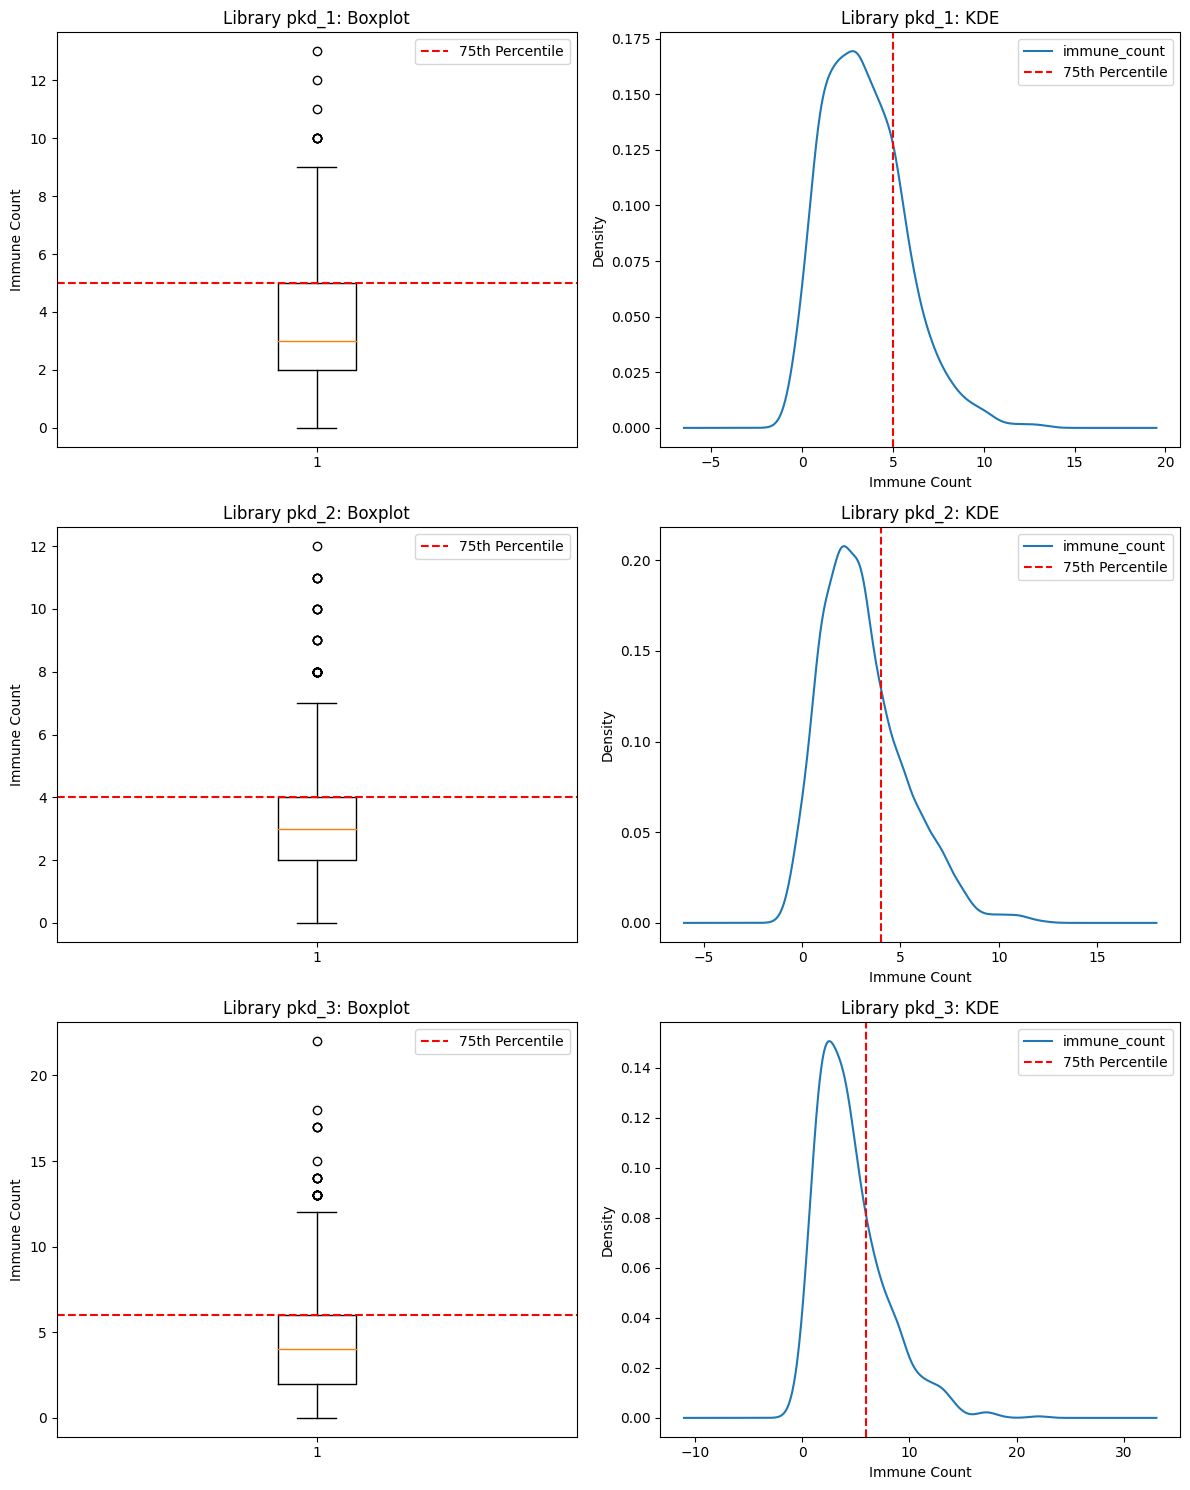

In [46]:
# Group data by 'library_id' and process each library separately
libraries = adata_layers.obs['library_id'].unique()

# Create subplots for each library
fig, axs = plt.subplots(len(libraries), 2, figsize=(12, 5 * len(libraries)))

for i, library in enumerate(libraries):
    library_data = adata_layers.obs[adata_layers.obs['library_id'] == library]
    immune_count = library_data['immune_count']
    
    # Calculate the 75th percentile for this library
    percentile_75 = immune_count.quantile(0.75)
    
    # Boxplot
    axs[i, 0].boxplot(immune_count)
    axs[i, 0].set_title(f'Library {library}: Boxplot')
    axs[i, 0].axhline(percentile_75, color='red', linestyle='--', label='75th Percentile')
    axs[i, 0].set_ylabel('Immune Count')
    axs[i, 0].legend()
    
    # KDE Plot
    immune_count.plot.kde(ax=axs[i, 1])
    axs[i, 1].set_title(f'Library {library}: KDE')
    axs[i, 1].axvline(percentile_75, color='red', linestyle='--', label='75th Percentile')
    axs[i, 1].set_xlabel('Immune Count')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
for library in adata_layers.obs['library_id'].unique():
    library_data = adata_layers[adata_layers.obs['library_id'] == library]
    
    quantile_75 = np.quantile(library_data.obs['immune_count'], 0.70)
    
    bc_pos = library_data[library_data.obs['immune_count'] >= quantile_75].obs_names
    bc_neg = library_data[library_data.obs['immune_count'] < quantile_75].obs_names
    
    adata_layers.obs.loc[adata_layers.obs.index.isin(bc_pos), "posneg"] = "high"
    adata_layers.obs.loc[adata_layers.obs.index.isin(bc_neg), "posneg"] = "low"

adata_layers.obs['posneg'] = adata_layers.obs['posneg'].astype('category')


... storing 'layers' as categorical
... storing 'layers' as categorical
... storing 'layers' as categorical


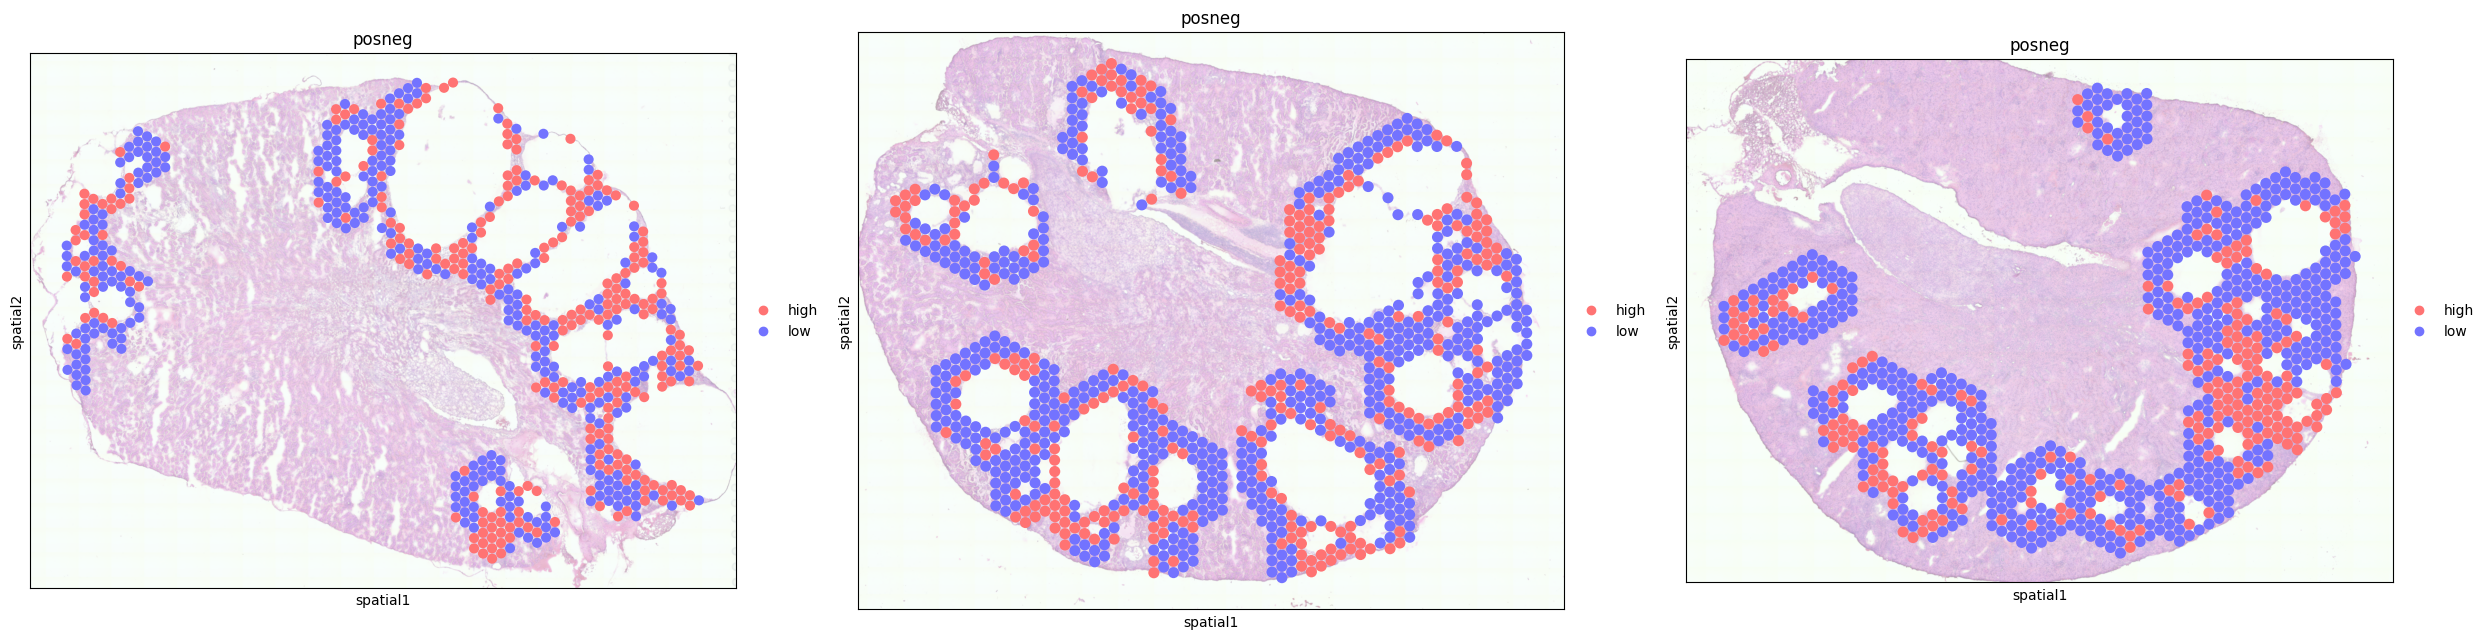

In [50]:
fig, axs = plt.subplots(1,3, figsize=(25, 10))

for i, library in enumerate(
    ["pkd_1", "pkd_2", "pkd_3"]
):
    ad = adata_layers[adata_layers.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color=["posneg"],
        size=1.5,
        alpha_img=0.5,
        palette=['#FF7373', '#7373ff'],
        show=False,
        ax=axs[i]
    )
plt.tight_layout()
plt.savefig('spatial_highlow_3_kidneys.pdf')

In [51]:
pkd_1_segmentation_dc_new = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_1_v1/pkd_1_tangram_ct_count_denoised_ZimmermanHumphreysMuto.csv", index_col=0 )
pkd_2_segmentation_dc_new = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_2_v1/pkd_2_tangram_ct_count_denoised_ZimmermanHumphreysMuto.csv", index_col=0 )
pkd_3_segmentation_dc_new = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/outputs/tangram_outputs_with_PKD/pkd_3_v1/pkd_3_tangram_ct_count_denoised_ZimmermanHumphreysMuto.csv", index_col=0 )

In [52]:
pkd_2_segmentation_dc_new.columns

Index(['x', 'y', 'cell_n', 'centroids', 'MD', 'Lyc6 low Macrophages', 'Podo',
       'TAL', 'T lymph', 'PTS3', 'LOH', 'B lymph', 'Glom-Endo',
       'Gzma+ CD8+ T lymph', 'PC', 'NKT1', 'Spp1+ Resident Macrophages ',
       'PT-FR', 'DCT-CNT', 'Fib', 'Neutro', 'Lyc6 high Macrophages',
       'CD4+ Th17', 'PT-AcInj', 'CD4+ T regs', 'PTS1', 'Endo', 'ICB', 'PTS2',
       'Gzma low NK', 'ATL', 'Per', 'PT-Inj', 'Gzma+ NK', 'T1 B lymph',
       'Myofib', 'PT-R', 'Trans-PTC', 'DTL-ATL', 'Mrc1+ Resident Macrophages',
       'DCT', 'CD-Trans', 'DTL', 'NK', 'CD4+ T lymph', 'PEC', 'Memory B lymph',
       'CNT', 'Macro', 'B1 B lymph', 'DC', 'T3/Follicular B lymph', 'ICA',
       'PTS3T2'],
      dtype='object')

In [53]:
pkd_1_segmentation_dc_new['Immune'] = pkd_1_segmentation_dc_new['Macro'] + pkd_1_segmentation_dc_new['Lyc6 high Macrophages'] + pkd_1_segmentation_dc_new['Lyc6 low Macrophages'] + pkd_1_segmentation_dc_new['Mrc1+ Resident Macrophages'] + pkd_1_segmentation_dc_new['Spp1+ Resident Macrophages '] +  pkd_1_segmentation_dc_new['Gzma+ NK'] + pkd_1_segmentation_dc_new['Gzma low NK'] + pkd_1_segmentation_dc_new['B lymph'] + pkd_1_segmentation_dc_new['T3/Follicular B lymph'] + pkd_1_segmentation_dc_new['T1 B lymph'] + pkd_2_segmentation_dc_new['T lymph'] + pkd_1_segmentation_dc_new['CD4+ T regs'] + pkd_1_segmentation_dc_new['DC'] + pkd_1_segmentation_dc_new['Neutro'] + pkd_1_segmentation_dc_new['B1 B lymph'] + pkd_1_segmentation_dc_new['Memory B lymph'] +  pkd_1_segmentation_dc_new['CD4+ T lymph'] + pkd_1_segmentation_dc_new['Gzma+ NK'] + pkd_1_segmentation_dc_new['Gzma low NK'] + pkd_1_segmentation_dc_new['CD4+ T regs'] + pkd_1_segmentation_dc_new['CD4+ Th17'] + pkd_1_segmentation_dc_new['Neutro'] + pkd_1_segmentation_dc_new['NKT1']
pkd_2_segmentation_dc_new['Immune'] = pkd_2_segmentation_dc_new['Macro'] + pkd_2_segmentation_dc_new['Lyc6 high Macrophages'] + pkd_2_segmentation_dc_new['Lyc6 low Macrophages'] + pkd_2_segmentation_dc_new['Mrc1+ Resident Macrophages'] + pkd_2_segmentation_dc_new['Spp1+ Resident Macrophages '] +  pkd_2_segmentation_dc_new['Gzma+ NK'] + pkd_2_segmentation_dc_new['Gzma low NK'] + pkd_2_segmentation_dc_new['B lymph'] + pkd_2_segmentation_dc_new['T3/Follicular B lymph'] + pkd_2_segmentation_dc_new['T1 B lymph'] + pkd_2_segmentation_dc_new['T lymph'] + pkd_2_segmentation_dc_new['CD4+ T regs'] + pkd_2_segmentation_dc_new['DC'] + pkd_2_segmentation_dc_new['Neutro'] + pkd_2_segmentation_dc_new['B1 B lymph'] + pkd_2_segmentation_dc_new['Memory B lymph'] +  pkd_2_segmentation_dc_new['CD4+ T lymph'] + pkd_2_segmentation_dc_new['Gzma+ NK'] + pkd_2_segmentation_dc_new['Gzma low NK'] + pkd_2_segmentation_dc_new['CD4+ T regs'] + pkd_2_segmentation_dc_new['CD4+ Th17'] + pkd_2_segmentation_dc_new['Neutro'] + pkd_2_segmentation_dc_new['NKT1']
pkd_3_segmentation_dc_new['Immune'] = pkd_3_segmentation_dc_new['Macro'] + pkd_3_segmentation_dc_new['Lyc6 high Macrophages'] + pkd_3_segmentation_dc_new['Lyc6 low Macrophages'] + pkd_3_segmentation_dc_new['Mrc1+ Resident Macrophages'] + pkd_3_segmentation_dc_new['Spp1+ Resident Macrophages '] +  pkd_3_segmentation_dc_new['Gzma+ NK'] + pkd_3_segmentation_dc_new['Gzma low NK'] + pkd_3_segmentation_dc_new['B lymph'] + pkd_3_segmentation_dc_new['T3/Follicular B lymph'] + pkd_3_segmentation_dc_new['T1 B lymph'] + pkd_3_segmentation_dc_new['T lymph'] + pkd_3_segmentation_dc_new['CD4+ T regs'] + pkd_3_segmentation_dc_new['DC'] + pkd_3_segmentation_dc_new['Neutro'] + pkd_3_segmentation_dc_new['B1 B lymph'] + pkd_3_segmentation_dc_new['Memory B lymph'] +  pkd_3_segmentation_dc_new['CD4+ T lymph'] + pkd_3_segmentation_dc_new['Gzma+ NK'] + pkd_3_segmentation_dc_new['Gzma low NK'] + pkd_3_segmentation_dc_new['CD4+ T regs'] + pkd_3_segmentation_dc_new['CD4+ Th17'] + pkd_3_segmentation_dc_new['Neutro'] + pkd_3_segmentation_dc_new['NKT1']

In [54]:
column_names = [
    "Macro",
    "Lyc6 high Macrophages",
    "Lyc6 low Macrophages",
    "Mrc1+ Resident Macrophages",
    "Spp1+ Resident Macrophages ",
    "Gzma+ NK",
    "Gzma low NK",
    "B lymph",
    "T3/Follicular B lymph",
    "T1 B lymph",
    "T lymph",  # from pkd_2_segmentation_dc_new
    "CD4+ T regs",
    "DC",
    "Neutro",
    "B1 B lymph",
    "Memory B lymph",
    "CD4+ T lymph",
    "Gzma+ NK",
    "Gzma low NK",
    "CD4+ T regs",
    "CD4+ Th17",
    "Neutro",
    "NKT1",
    'Gzma+ CD8+ T lymph',
    
]

In [55]:
pkd_1_segmentation_dc_new.drop(column_names, axis=1, inplace=True)
pkd_2_segmentation_dc_new.drop(column_names, axis=1, inplace=True)
pkd_3_segmentation_dc_new.drop(column_names, axis=1, inplace=True)

In [56]:
pkd_3_segmentation_dc_new.columns

Index(['x', 'y', 'cell_n', 'centroids', 'MD', 'Podo', 'TAL', 'PTS3', 'LOH',
       'Glom-Endo', 'PC', 'PT-FR', 'DCT-CNT', 'Fib', 'PT-AcInj', 'PTS1',
       'Endo', 'ICB', 'PTS2', 'ATL', 'Per', 'PT-Inj', 'Myofib', 'PT-R',
       'Trans-PTC', 'DTL-ATL', 'DCT', 'CD-Trans', 'DTL', 'NK', 'PEC', 'CNT',
       'ICA', 'PTS3T2', 'Immune'],
      dtype='object')

In [57]:
pkd_2_segmentation_dc_new['PT'] = pkd_1_segmentation_dc_new['PTS1'] + pkd_1_segmentation_dc_new['PTS2'] + pkd_1_segmentation_dc_new['PTS3'] + pkd_1_segmentation_dc_new['PTS3T2']
pkd_2_segmentation_dc_new['PT'] = pkd_2_segmentation_dc_new['PTS1'] + pkd_2_segmentation_dc_new['PTS2'] + pkd_2_segmentation_dc_new['PTS3'] + pkd_2_segmentation_dc_new['PTS3T2']
pkd_2_segmentation_dc_new['PT'] = pkd_3_segmentation_dc_new['PTS1'] + pkd_3_segmentation_dc_new['PTS2'] + pkd_3_segmentation_dc_new['PTS3'] + pkd_3_segmentation_dc_new['PTS3T2']

In [58]:
pkd_1_segmentation_dc_new.drop(['PTS1', 'PTS2', 'PTS3', 'PTS3T2'], axis=1, inplace=True)
pkd_2_segmentation_dc_new.drop(['PTS1', 'PTS2', 'PTS3', 'PTS3T2'], axis=1, inplace=True)
pkd_3_segmentation_dc_new.drop(['PTS1', 'PTS2', 'PTS3', 'PTS3T2'], axis=1, inplace=True)

In [59]:
pkd_1_segmentation_dc_new['LOH'] = pkd_1_segmentation_dc_new['TAL'] + pkd_1_segmentation_dc_new['ATL'] + pkd_1_segmentation_dc_new['DTL'] + pkd_1_segmentation_dc_new['DTL-ATL']
pkd_2_segmentation_dc_new['LOH'] = pkd_2_segmentation_dc_new['TAL'] + pkd_2_segmentation_dc_new['ATL'] + pkd_2_segmentation_dc_new['DTL'] + pkd_2_segmentation_dc_new['DTL-ATL']
pkd_3_segmentation_dc_new['LOH'] = pkd_3_segmentation_dc_new['TAL'] + pkd_3_segmentation_dc_new['ATL'] + pkd_3_segmentation_dc_new['DTL'] + pkd_3_segmentation_dc_new['DTL-ATL']

In [60]:
pkd_1_segmentation_dc_new.drop(['TAL', 'ATL', 'DTL', 'DTL-ATL'], axis=1, inplace=True)
pkd_2_segmentation_dc_new.drop(['TAL', 'ATL', 'DTL', 'DTL-ATL'], axis=1, inplace=True)
pkd_3_segmentation_dc_new.drop(['TAL', 'ATL', 'DTL', 'DTL-ATL'], axis=1, inplace=True)

In [61]:
pkd_1_segmentation_dc_new['DCT_2'] = pkd_1_segmentation_dc_new['DCT'] + pkd_1_segmentation_dc_new['DCT-CNT']
pkd_1_segmentation_dc_new['DCT'] = pkd_1_segmentation_dc_new['DCT_2']
del pkd_1_segmentation_dc_new['DCT_2']
del pkd_1_segmentation_dc_new['DCT-CNT']
pkd_2_segmentation_dc_new['DCT_2'] = pkd_2_segmentation_dc_new['DCT'] + pkd_2_segmentation_dc_new['DCT-CNT']
pkd_2_segmentation_dc_new['DCT'] = pkd_2_segmentation_dc_new['DCT_2']
del pkd_2_segmentation_dc_new['DCT_2']
del pkd_2_segmentation_dc_new['DCT-CNT']
pkd_3_segmentation_dc_new['DCT_2'] = pkd_3_segmentation_dc_new['DCT'] + pkd_3_segmentation_dc_new['DCT-CNT']
pkd_3_segmentation_dc_new['DCT'] = pkd_3_segmentation_dc_new['DCT_2']
del pkd_3_segmentation_dc_new['DCT_2']
del pkd_3_segmentation_dc_new['DCT-CNT']

In [62]:
pkd_1_segmentation_dc_new['Endo_2'] = pkd_1_segmentation_dc_new['Endo'] + pkd_1_segmentation_dc_new['Glom-Endo']
pkd_1_segmentation_dc_new['Endo'] = pkd_1_segmentation_dc_new['Endo_2']
del pkd_1_segmentation_dc_new['Endo_2']
del pkd_1_segmentation_dc_new['Glom-Endo']
pkd_2_segmentation_dc_new['Endo_2'] = pkd_2_segmentation_dc_new['Endo'] + pkd_2_segmentation_dc_new['Glom-Endo']
pkd_2_segmentation_dc_new['Endo'] = pkd_2_segmentation_dc_new['Endo_2']
del pkd_2_segmentation_dc_new['Endo_2']
del pkd_2_segmentation_dc_new['Glom-Endo']
pkd_3_segmentation_dc_new['Endo_2'] = pkd_3_segmentation_dc_new['Endo'] + pkd_3_segmentation_dc_new['Glom-Endo']
pkd_3_segmentation_dc_new['Endo'] = pkd_3_segmentation_dc_new['Endo_2']
del pkd_3_segmentation_dc_new['Endo_2']
del pkd_3_segmentation_dc_new['Glom-Endo']

In [63]:
pkd_1_segmentation_dc_new['Fib_2'] = pkd_1_segmentation_dc_new['Fib'] + pkd_1_segmentation_dc_new['Myofib'] 
pkd_1_segmentation_dc_new['Fib'] = pkd_1_segmentation_dc_new['Fib_2'] 
del pkd_1_segmentation_dc_new['Fib_2']
del pkd_1_segmentation_dc_new['Myofib']
pkd_2_segmentation_dc_new['Fib_2'] = pkd_2_segmentation_dc_new['Fib'] + pkd_2_segmentation_dc_new['Myofib'] 
pkd_2_segmentation_dc_new['Fib'] = pkd_2_segmentation_dc_new['Fib_2'] 
del pkd_2_segmentation_dc_new['Fib_2']
del pkd_2_segmentation_dc_new['Myofib']
pkd_3_segmentation_dc_new['Fib_2'] = pkd_3_segmentation_dc_new['Fib'] + pkd_3_segmentation_dc_new['Myofib'] 
pkd_3_segmentation_dc_new['Fib'] = pkd_3_segmentation_dc_new['Fib_2'] 
del pkd_3_segmentation_dc_new['Fib_2']
del pkd_3_segmentation_dc_new['Myofib']

In [66]:
adata_layers.obs['cyst_immune'] = adata_layers.obs['layers'].astype(str) + '_' + adata_layers.obs['posneg'].astype(str)

In [68]:
pkd_1_segmentation_dc_layer1_pos = pkd_1_segmentation_dc_new[pkd_1_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer1_high'].obs.index.to_list())].copy()
pkd_1_segmentation_dc_layer1_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_1_segmentation_dc_layer1_neg = pkd_1_segmentation_dc_new[pkd_1_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer1_low'].obs.index.to_list())].copy()
pkd_1_segmentation_dc_layer1_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

pkd_1_segmentation_dc_layer2_pos = pkd_1_segmentation_dc_new[pkd_1_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer2_high'].obs.index.to_list())].copy()
pkd_1_segmentation_dc_layer2_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_1_segmentation_dc_layer2_neg = pkd_1_segmentation_dc_new[pkd_1_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer2_low'].obs.index.to_list())].copy()
pkd_1_segmentation_dc_layer2_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

pkd_1_segmentation_dc_layer3_pos = pkd_1_segmentation_dc_new[pkd_1_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer3_high'].obs.index.to_list())].copy()
pkd_1_segmentation_dc_layer3_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_1_segmentation_dc_layer3_neg = pkd_1_segmentation_dc_new[pkd_1_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer3_low'].obs.index.to_list())].copy()
pkd_1_segmentation_dc_layer3_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

In [69]:
pkd_2_segmentation_dc_layer1_pos = pkd_2_segmentation_dc_new[pkd_2_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer1_high'].obs.index.to_list())].copy()
pkd_2_segmentation_dc_layer1_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_2_segmentation_dc_layer1_neg = pkd_2_segmentation_dc_new[pkd_2_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer1_low'].obs.index.to_list())].copy()
pkd_2_segmentation_dc_layer1_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

pkd_2_segmentation_dc_layer2_pos = pkd_2_segmentation_dc_new[pkd_2_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer2_high'].obs.index.to_list())].copy()
pkd_2_segmentation_dc_layer2_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_2_segmentation_dc_layer2_neg = pkd_2_segmentation_dc_new[pkd_2_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer2_low'].obs.index.to_list())].copy()
pkd_2_segmentation_dc_layer2_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

pkd_2_segmentation_dc_layer3_pos = pkd_2_segmentation_dc_new[pkd_2_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer3_high'].obs.index.to_list())].copy()
pkd_2_segmentation_dc_layer3_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_2_segmentation_dc_layer3_neg = pkd_2_segmentation_dc_new[pkd_2_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer3_low'].obs.index.to_list())].copy()
pkd_2_segmentation_dc_layer3_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

In [70]:
pkd_3_segmentation_dc_layer1_pos = pkd_3_segmentation_dc_new[pkd_3_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer1_high'].obs.index.to_list())].copy()
pkd_3_segmentation_dc_layer1_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_3_segmentation_dc_layer1_neg = pkd_3_segmentation_dc_new[pkd_3_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer1_low'].obs.index.to_list())].copy()
pkd_3_segmentation_dc_layer1_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

pkd_3_segmentation_dc_layer2_pos = pkd_3_segmentation_dc_new[pkd_3_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer2_high'].obs.index.to_list())].copy()
pkd_3_segmentation_dc_layer2_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_3_segmentation_dc_layer2_neg = pkd_3_segmentation_dc_new[pkd_3_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer2_low'].obs.index.to_list())].copy()
pkd_3_segmentation_dc_layer2_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

pkd_3_segmentation_dc_layer3_pos = pkd_3_segmentation_dc_new[pkd_3_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer3_high'].obs.index.to_list())].copy()
pkd_3_segmentation_dc_layer3_pos.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)
pkd_3_segmentation_dc_layer3_neg = pkd_3_segmentation_dc_new[pkd_3_segmentation_dc_new.index.isin(adata_layers[adata_layers.obs['cyst_immune'] == 'layer3_low'].obs.index.to_list())].copy()
pkd_3_segmentation_dc_layer3_neg.drop(columns=['x', 'y', 'cell_n', 'centroids'], inplace=True)

In [71]:
pkd_2_segmentation_dc_layer1_pos.sum(axis=0) + pkd_1_segmentation_dc_layer1_pos.sum(axis=0) + pkd_3_segmentation_dc_layer1_pos.sum(axis=0)

CD-Trans       13.0
CNT            35.0
DCT           151.0
Endo          279.0
Fib           357.0
ICA           129.0
ICB            11.0
Immune       1885.0
LOH           355.0
MD             16.0
NK             40.0
PC            260.0
PEC           119.0
PT              NaN
PT-AcInj        7.0
PT-FR         820.0
PT-Inj         44.0
PT-R           22.0
Per            52.0
Podo           95.0
Trans-PTC      77.0
dtype: float64

In [72]:
pos_neg_layers_ct_count = pd.DataFrame({'layer1_high': pkd_2_segmentation_dc_layer1_pos.sum(axis=0) + pkd_1_segmentation_dc_layer1_pos.sum(axis=0) + pkd_3_segmentation_dc_layer1_pos.sum(axis=0), 'layer2_high': pkd_1_segmentation_dc_layer2_pos.sum(axis=0) + pkd_2_segmentation_dc_layer2_pos.sum(axis=0) + pkd_3_segmentation_dc_layer2_pos.sum(axis=0), 'layer3_high': pkd_1_segmentation_dc_layer3_pos.sum(axis=0) + pkd_2_segmentation_dc_layer3_pos.sum(axis=0) + pkd_3_segmentation_dc_layer3_pos.sum(axis=0), 'layer1_low': pkd_1_segmentation_dc_layer1_neg.sum(axis=0) + pkd_2_segmentation_dc_layer1_neg.sum(axis=0) + pkd_3_segmentation_dc_layer1_neg.sum(axis=0), 'layer2_low': pkd_1_segmentation_dc_layer2_neg.sum(axis=0) + pkd_2_segmentation_dc_layer2_neg.sum(axis=0) + pkd_3_segmentation_dc_layer2_neg.sum(axis=0), 'layer3_low': pkd_1_segmentation_dc_layer3_neg.sum(axis=0) + pkd_2_segmentation_dc_layer3_neg.sum(axis=0) + pkd_3_segmentation_dc_layer3_neg.sum(axis=0)})

In [74]:
pos_neg_layers_ct_count = pos_neg_layers_ct_count.div(pos_neg_layers_ct_count.sum(axis=0),  axis=1).multiply(100)

In [76]:
import pickle as pkl

In [78]:
pos_neg_layers_ct_count = pos_neg_layers_ct_count.T

In [80]:
my_order = ['PT', 'PT-Inj', 'PT-AcInj', 'PT-FR', 'PT-R', 'Trans-PTC', 'Podo', 'LOH', 'CNT', 'DCT', 'PC', 'ICA', 'ICB', 'CD-Trans', 'Endo', 'Fib', 'Per',  'Immune']

In [82]:
pos_neg_layers_ct_count = pos_neg_layers_ct_count[my_order]

In [84]:
pos_neg_layers_ct_count = pos_neg_layers_ct_count.reindex(sorted(pos_neg_layers_ct_count.columns), axis=1)

In [85]:
import pickle as pkl
palette = pkl.load( open( "/exports/archive/hg-groep-peters/Healthy_Mouse_Atlas_Claudio/KidneyAtlas/predicted_celltype_palette_highres_2.pkl", "rb" ) )

In [86]:
palette['Myofib']  = '#963b00'
palette['CD4+ T lymph'] = '#c4bfeb'
palette['Gzma+ CD8+ T lymph'] = '#88bf35'
palette['Memory B lymph'] = '#a691b4'
palette['NKT1'] = '#01a7f4'
palette['Trans-PTC'] = '#321fa0'
palette['PT-FR'] = '#03655c'
palette['PT-R'] = '#059e3f'
palette['PT-AcInj'] = '#615318'
palette['PT-Inj'] = '#fc362f'

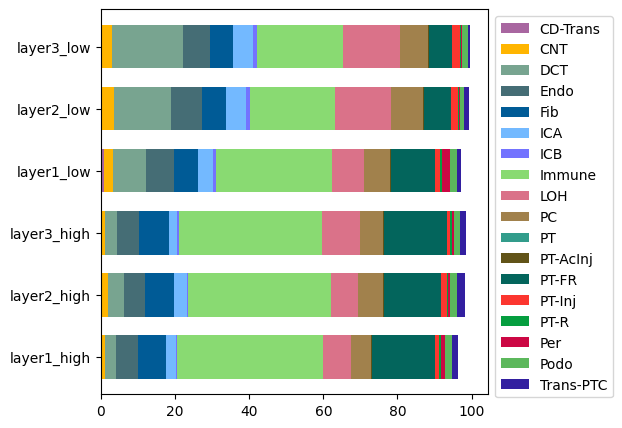

In [89]:
custom_order = ["layer1_high", "layer2_high", "layer3_high", "layer1_low", "layer2_low", "layer3_low"]  # your desired y-axis order
pos_neg_layers_ct_count = pos_neg_layers_ct_count.reindex(custom_order)

pos_neg_layers_ct_count.plot.barh(
    stacked=True,
    color=palette,
    grid=False,
    figsize=(5,5),
    width=0.7
).legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(
    '/exports/humgen/cnovellarausell/SevtapSpatial/Notebooks/figures-ct-frequencies/pos_neg_immune_count_frequencies_layers_final_withPKD.pdf', 
    bbox_inches='tight'
)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'MATH': 45 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'six', 'space', 'three', 'two', 'u', 'underscore', 'w', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 41, 43, 44, 47, 49, 50, 51, 53, 55, 66, 68, 69, 70, 71, 72, 74, 75, 76, 77, 79, 80, 81, 82, 85, 86, 88, 90, 92]
Closed glyph list over 'MATH': 45 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'six', 'space', 'three', '

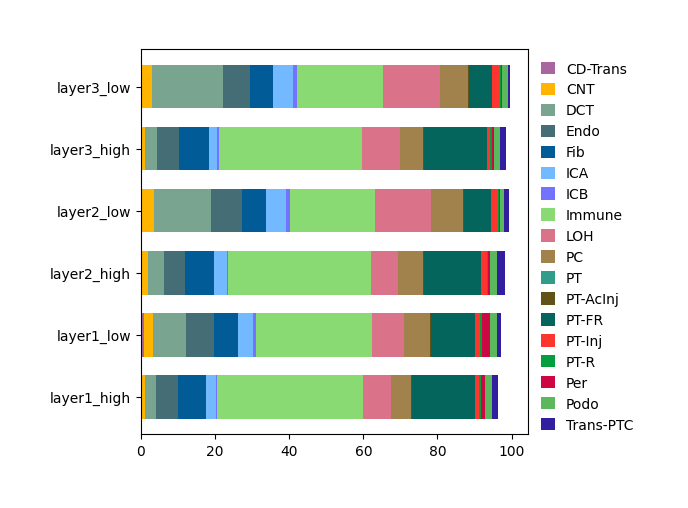

In [259]:
pos_neg_layers_ct_count.plot.barh(stacked=True, color=palette, grid=False,figsize=(5,5),width=0.7 ).legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('/exports/humgen/cnovellarausell/SevtapSpatial/Notebooks/figures-ct-frequencies/pos_neg_immune_count_frequencies_layers_final_withPKD.pdf', bbox_inches='tight')

In [49]:
## --------------- ##
## Immune low only ##
## --------------- ##

adata_cystic_immune_low = adata_layers[adata_layers.obs.posneg == 'low'].copy()
adata_cystic_immune_low.obs['sample_context'] = adata_cystic_immune_low.obs["layers"].astype(str) + "_" + adata_cystic_immune_low.obs["library_id"].astype(str)

## ------------------- ##
## Immune low and high ##
## ------------------- ##
adata_immune_high_low = adata_layers.copy()
adata_immune_high_low.obs['sample_context'] = adata_layers.obs["posneg"].astype(str) + "_" + adata_layers.obs["library_id"].astype(str)
adata_immune_high_low.obs["layered_CT"] = adata_immune_high_low.obs["Cell_type"].astype(str) + "_" + adata_immune_high_low.obs["layers"].astype(str)

## --------- ##
## noncystic ##
## --------- ##

adata_non_cystic = adata_st[adata_st.obs['layers'].isin(['noncystic'])].copy()

In [237]:
adata_cystic_immune_low.write_h5ad("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/adata_cystic_immune_low_V2.h5ad")
adata_immune_high_low.write_h5ad("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/adata_cystc_immune_highandlow_V2.h5ad")
adata_non_cystic.write_h5ad("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/adata_non_cystic_V2.h5ad")

... storing 'layers' as categorical
... storing 'sample_context' as categorical
... storing 'layers' as categorical
... storing 'sample_context' as categorical
... storing 'layered_CT' as categorical
... storing 'layers' as categorical


In [14]:
adata_cystic_immune_low = sc.read_h5ad("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/adata_cystic_immune_low_V2.h5ad")
adata_immune_high_low = sc.read_h5ad("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/adata_cystc_immune_highandlow_V2.h5ad")
adata_non_cystic = sc.read_h5ad("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/adata_non_cystic_V2.h5ad")

In [52]:
li.method.show_methods()

Method Name Magnitude Score Specificity Score  \
0        CellPhoneDB        lr_means   cellphone_pvals   
0         Connectome       expr_prod     scaled_weight   
0             log2FC            None          lr_logfc   
0              NATMI       expr_prod       spec_weight   
0  SingleCellSignalR         lrscore              None   
0     Rank_Aggregate  magnitude_rank  specificity_rank   
0     Geometric Mean       lr_gmeans       gmean_pvals   
0          scSeqComm     inter_score              None   
0           CellChat        lr_probs    cellchat_pvals   

                                           Reference  
0  Efremova, M., Vento-Tormo, M., Teichmann, S.A....  
0  Raredon, M.S.B., Yang, J., Garritano, J., Wang...  
0  Dimitrov, D., Türei, D., Garrido-Rodriguez, M....  
0  Hou, R., Denisenko, E., Ong, H.T., Ramilowski,...  
0  Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ...  
0  Dimitrov, D., Türei, D., Garrido-Rodriguez, M....  
0  CellPhoneDBv2's permutation approach applied t...  
0  Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ...  
0  Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha...

In [15]:
mapping = sc.queries.biomart_annotations(
    "mmusculus",
    [ "external_gene_name", "description"],
).set_index("external_gene_name")

mapping = mapping['description']

In [16]:
mapping

external_gene_name
mt-Tf      mitochondrially encoded tRNA phenylalanine [So...
mt-Rnr1    mitochondrially encoded 12S rRNA [Source:MGI S...
mt-Tv      mitochondrially encoded tRNA valine [Source:MG...
mt-Rnr2    mitochondrially encoded 16S rRNA [Source:MGI S...
mt-Tl1     mitochondrially encoded tRNA leucine 1 [Source...
                                 ...                        
Gm13986    predicted gene 13986 [Source:MGI Symbol;Acc:MG...
Gm13330    predicted gene 13330 [Source:MGI Symbol;Acc:MG...
Gm14029    predicted gene 14029 [Source:MGI Symbol;Acc:MG...
Gm3363     predicted gene 3363 [Source:MGI Symbol;Acc:MGI...
Gm14424    predicted gene 14424 [Source:MGI Symbol;Acc:MG...
Name: description, Length: 61956, dtype: object

In [296]:
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
methods = [singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean]
new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [ ]:
non_cystic_liana = new_rank_aggregate.by_sample(adata_non_cystic,
                                                sample_key='library_id',
                                                      groupby="Cell_type",
                           resource_name = 'MouseConsensus',
                           # expr_prop=expr_threshold, # must be expressed in expr_prop fraction of cells
                           min_cells = 1,
                           n_perms = 5000,
                           use_raw = True, # run on log- and library-normalized counts
                           verbose = True,
                           inplace = False,
                        return_all_lrs=True,
                          )

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
Now running: pkd_3: 100%|██████████| 3/3 [03:10<00:00, 63.60s/it]

CPU times: user 3min 5s, sys: 5.14 s, total: 3min 10s
Wall time: 3min 10s


In [310]:
# Function to clean up the full name
def clean_name(name):
    import re
    return re.sub(r' \[Source:.*\]', '', name)

# Function to get the full name for a complex
def map_complex(complex, mapping):
    symbols = complex.split('_')
    full_names = [clean_name(mapping.get(symbol, symbol)) for symbol in symbols]
    return ' + '.join(full_names)

In [311]:
# Map ligand and receptor complex to their full names, and clean them
non_cystic_liana['ligand_full_name'] = non_cystic_liana['ligand_complex'].apply(lambda x: clean_name(mapping.get(x, x)))
non_cystic_liana['receptor_full_name'] = non_cystic_liana['receptor_complex'].apply(lambda x: map_complex(x, mapping))

In [312]:
non_cystic_liana.to_excel(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Non_cystic/LIANA_table_unfiltered_all_methods_by_sample.xlsx")

In [ ]:
immune_low_liana = new_rank_aggregate.by_sample(adata_cystic_immune_low,
                                   sample_key='sample_context',
                           groupby='Cell_type',
                           resource_name = 'MouseConsensus',
                           expr_prop=expr_threshold, # must be expressed in expr_prop fraction of cells
                           min_cells = 1,
                           n_perms = 5000,
                           use_raw = True, # run on log- and library-normalized counts
                           verbose = True,
                           inplace = False,
                          )

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports

CPU times: user 11min 40s, sys: 6.45 s, total: 11min 46s
Wall time: 11min 49s


In [302]:
##### Map ligand and receptor complex to their full names, and clean them
immune_low_liana['ligand_full_name'] = immune_low_liana['ligand_complex'].apply(lambda x: clean_name(mapping.get(x, x)))
immune_low_liana['receptor_full_name'] = immune_low_liana['receptor_complex'].apply(lambda x: map_complex(x, mapping))

In [303]:
immune_low_liana.to_excel(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/LIANA_table_all_methods.xlsx")

In [305]:
immune_high_low_liana = new_rank_aggregate.by_sample(adata_immune_high_low,
                                   sample_key='sample_context',
                           groupby='layered_CT',
                           resource_name = 'MouseConsensus',
                           expr_prop=1, # must be expressed in expr_prop fraction of cells
                           min_cells =expr_threshold,
                           n_perms = 5000,
                           use_raw = True, # run on log- and library-normalized counts
                           verbose = True,
                           inplace = False,
                          )

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports

In [257]:
immune_high_low_liana = li.method.rank_aggregate.by_sample(adata_immune_high_low,
                                   sample_key='sample_context',
                           groupby='layered_CT',
                           resource_name = 'MouseConsensus',
                           expr_prop=1, # must be expressed in expr_prop fraction of cells
                           min_cells =expr_threshold,
                           n_perms = 5000,
                           use_raw = True, # run on log- and library-normalized counts
                           verbose = True,
                           inplace = False,
                          )

/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports/archive/hg-funcgenom-research/cnovellarausell/conda_envs/cell2cell_py38/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/exports

In [306]:
# Map ligand and receptor complex to their full names, and clean them
immune_high_low_liana['ligand_full_name'] = immune_high_low_liana['ligand_complex'].apply(lambda x: clean_name(mapping.get(x, x)))
immune_high_low_liana['receptor_full_name'] = immune_high_low_liana['receptor_complex'].apply(lambda x: map_complex(x, mapping))

In [307]:
immune_high_low_liana.to_excel(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_high_vs_immune_low/LIANA_table_all_methids.xlsx")

In [55]:
non_cystic_liana = pd.read_excel(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Non_cystic/LIANA_table_unfiltered_all_methods_by_sample.xlsx", index_col=0)
immune_low_liana = pd.read_excel(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/LIANA_table_all_methods.xlsx", index_col=0)
immune_high_low_liana = pd.read_excel(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_high_vs_immune_low/LIANA_table_all_methids.xlsx", index_col=0)

### Filter

In [57]:
import re

# Create a library_id column by extracting pkd_1, pkd_2, etc.
immune_low_liana["library_id"] = immune_low_liana["sample_context"].str.extract(r'(pkd_\d+)')
merged_df = pd.merge(
    immune_low_liana,
    non_cystic_liana,
    left_on=['library_id', 'source', 'target', 'ligand_complex', 'receptor_complex'],
    right_on=['library_id', 'source', 'target', 'ligand_complex', 'receptor_complex'],
    suffixes=('', '_non_cystic')
)

merged_df['lr_ratio'] = merged_df['lr_means'] / merged_df['lr_means_non_cystic']

# Filter rows 
filtered_df = merged_df[
    merged_df['lr_means'] >= 2 * merged_df['lr_means_non_cystic']
]

# Grab all original immune_low_liana columns plus the ratio
immune_cols = immune_low_liana.columns.tolist()
cols_to_keep = immune_cols + ['lr_ratio']
immune_low_liana_filtered = filtered_df[cols_to_keep]

In [11]:
immune_low_liana_filtered.target.value_counts()

Fib               742
Podo              643
FR-PT + Immune    531
DCT-CNT           199
PTS3              198
CD-IC             148
PTS1/2            131
Inj PT             93
PTS3T2             58
Name: target, dtype: int64

In [ ]:
immune_low_liana_filtered.to_excel('/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/' +
f'Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/' + 
'LIANA_table_filtered_2x_expressed_in_cyst.xlsx')

In [11]:
immune_low_liana_filtered = pd.read_excel('/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/' +
f'Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/' + 
'LIANA_table_filtered_2x_expressed_in_cyst.xlsx')

## Tensor cell2cell

### Immune low

In [ ]:
immune_low_liana.shape, immune_low_liana_filtered.shape

#### Non filtered for ratios

In [19]:
sorted_samples = sorted(immune_low_liana['sample_context'].unique())
sorted_samples

['layer1_pkd_1',
 'layer1_pkd_2',
 'layer1_pkd_3',
 'layer2_pkd_1',
 'layer2_pkd_2',
 'layer2_pkd_3',
 'layer3_pkd_1',
 'layer3_pkd_2',
 'layer3_pkd_3']

In [20]:
immune_low_liana

sample_context          source          target ligand_complex  \
0       layer1_pkd_1           CD-IC  FR-PT + Immune            App   
1       layer1_pkd_1  FR-PT + Immune  FR-PT + Immune            App   
2       layer1_pkd_1            Podo  FR-PT + Immune            App   
3       layer1_pkd_1            PTS3  FR-PT + Immune            App   
4       layer1_pkd_1           CD-IC  FR-PT + Immune            App   
...              ...             ...             ...            ...   
73427   layer3_pkd_3            PTS3             Fib         Lgals3   
73428   layer3_pkd_3            PTS3             Fib          Lamb1   
73429   layer3_pkd_3          PTS3T2             Fib      Serpina1a   
73430   layer3_pkd_3          PTS3T2             Fib         Col4a1   
73431   layer3_pkd_3             Fib          PTS1/2       Lgals3bp   

      receptor_complex   lrscore  expr_prod  scaled_weight  lr_means  \
0                 Cd74  0.922290   7.766627       0.833183  2.830934   
1                 Cd74  0.919955   7.283124       0.644490  2.758302   
2                 Cd74  0.919882   7.268773       0.638889  2.756147   
3                 Cd74  0.916498   6.642322       0.394408  2.662042   
4                 Rpsa  0.917147   6.756452       0.806594  2.614472   
...                ...       ...        ...            ...       ...   
73427             Mcam  0.778077   0.696341       1.396385  0.836691   
73428             Dag1  0.766661   0.611524       0.336236  0.784903   
73429             Lrp1  0.804063   0.953964       1.075955  0.985783   
73430             Sdc1  0.775643   0.677058       0.528074  0.838549   
73431            Itgb1  0.782369   0.732087       0.079553  0.856416   

       cellphone_pvals  ...  lr_logfc  lr_probs  cellchat_pvals  lr_gmeans  \
0               0.0000  ...  0.846450  0.224168          0.0000   2.786867   
1               0.0000  ...  0.887531  0.212512          0.0000   2.698726   
2               0.0020  ...  0.732568  0.210521          0.0078   2.696066   
3               0.0000  ...  0.617988  0.194414          0.0014   2.577270   
4               0.0016  ...  0.496891  0.200070          0.0072   2.599318   
...                ...  ...       ...       ...             ...        ...   
73427           0.0004  ...  0.618285  0.025147          0.0012   0.834471   
73428           0.1836  ...  0.107633  0.023547          0.1956   0.782000   
73429           0.0014  ...  0.661951  0.034932          0.0004   0.976711   
73430           0.2144  ...  0.028299  0.027708          0.0726   0.822835   
73431           0.4004  ... -0.046304  0.030070          0.3378   0.855621   

       gmean_pvals  specificity_rank  magnitude_rank  \
0                0          0.004757    4.344757e-10   
1                0          0.002184    5.161038e-09   
2                0          0.107572    6.940233e-09   
3                0          0.080730    7.038849e-08   
4                0          0.038740    7.936828e-08   
...            ...               ...             ...   
73427            0          0.009948    1.000000e+00   
73428            0          1.000000    1.000000e+00   
73429            0          0.018486    1.000000e+00   
73430            0          1.000000    1.000000e+00   
73431            0          1.000000    1.000000e+00   

                                        ligand_full_name  \
0                         amyloid beta precursor protein   
1                         amyloid beta precursor protein   
2                         amyloid beta precursor protein   
3                         amyloid beta precursor protein   
4                         amyloid beta precursor protein   
...                                                  ...   
73427               lectin, galactose binding, soluble 3   
73428                                         laminin B1   
73429  serine (or cysteine) peptidase inhibitor, clad...   
73430                         collagen, type IV, alpha 1   
73431  lectin, gal

In [21]:
immune_low_tensor = li.multi.to_tensor_c2c(liana_res=immune_low_liana, # LIANA's dataframe containing results
                                sample_key='sample_context', # Column name of the samples
                                source_key='source', # Column name of the sender cells
                                target_key='target', # Column name of the receiver cells
                                ligand_key='ligand_complex', # Column name of the ligands
                                receptor_key='receptor_complex', # Column name of the receptors
                                score_key='magnitude_rank', # Column name of the communication scores to use
                                non_negative = True, # set negative values to 0
                                inverse_fun=lambda x: 1 - x, # Transformation function
                                non_expressed_fill=None, # Value to replace missing values with
                                how='outer', # What to include across all samples
                                lr_fill=np.nan, # What to fill missing LRs with
                                cell_fill =np.nan, # What to fill missing cell types with
                                #outer_fraction=0.25, # Fraction of samples as threshold to include cells and LR pairs.
                                lr_sep='^', # How to separate ligand and receptor names to name LR pair
                                context_order=sorted_samples, # Order to store the contexts in the tensor
                                sort_elements=True # Whether sorting alphabetically element names of each tensor dim. Does not apply for context order if context_order is passed.
                               )

100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


#### Filtered for ratios

In [13]:
sorted_samples = sorted(immune_low_liana_filtered['sample_context'].unique())
sorted_samples

['layer1_pkd_1',
 'layer1_pkd_2',
 'layer1_pkd_3',
 'layer2_pkd_1',
 'layer2_pkd_2',
 'layer2_pkd_3',
 'layer3_pkd_1',
 'layer3_pkd_2',
 'layer3_pkd_3']

In [14]:
immune_low_filtered_tensor = li.multi.to_tensor_c2c(liana_res=immune_low_liana_filtered, # LIANA's dataframe containing results
                                sample_key='sample_context', # Column name of the samples
                                source_key='source', # Column name of the sender cells
                                target_key='target', # Column name of the receiver cells
                                ligand_key='ligand_complex', # Column name of the ligands
                                receptor_key='receptor_complex', # Column name of the receptors
                                score_key='magnitude_rank', # Column name of the communication scores to use
                                non_negative = True, # set negative values to 0
                                inverse_fun=lambda x: 1 - x, # Transformation function
                                non_expressed_fill=None, # Value to replace missing values with
                                how='outer', # What to include across all samples
                                lr_fill=np.nan, # What to fill missing LRs with
                                cell_fill =np.nan, # What to fill missing cell types with
                                #outer_fraction=0.25, # Fraction of samples as threshold to include cells and LR pairs.
                                lr_sep='^', # How to separate ligand and receptor names to name LR pair
                                context_order=sorted_samples, # Order to store the contexts in the tensor
                                sort_elements=True # Whether sorting alphabetically element names of each tensor dim. Does not apply for context order if context_order is passed.
                               )

100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


In [60]:
context_dict_immune_low = dict()

for phenotype, df in adata_cystic_immune_low.obs.groupby('layers'):
    for layer_context in df['sample_context'].unique():
        context_dict_immune_low[layer_context] = phenotype

In [62]:
dimensions_dict_immune_low = [context_dict_immune_low, None, None, None]

In [63]:
meta_tensor_immune_low = c2c.tensor.generate_tensor_metadata(interaction_tensor=immune_low_tensor,
                                              metadata_dicts=[context_dict_immune_low, None, None, None],
                                              fill_with_order_elements=True
                                             )
meta_tensor_immune_low_filtered = c2c.tensor.generate_tensor_metadata(interaction_tensor=immune_low_filtered_tensor,
                                              metadata_dicts=[context_dict_immune_low, None, None, None],
                                              fill_with_order_elements=True
                                             )

In [90]:
c2c.io.export_variable_with_pickle(immune_low_tensor, f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/LIANA_Tensor.pkl")
c2c.io.export_variable_with_pickle(immune_low_filtered_tensor, f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/LIANA_filtered_Tensor.pkl")

/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_85%_threshold_V2/Immune_low/LIANA_Tensor.pkl  was correctly saved.
/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_85%_threshold_V2/Immune_low/LIANA_filtered_Tensor.pkl  was correctly saved.


In [91]:
c2c.io.export_variable_with_pickle(meta_tensor_immune_low, f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/LIANA_Tensor_Metadata.pkl")
c2c.io.export_variable_with_pickle(meta_tensor_immune_low_filtered, f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/LIANA_filtered_Tensor_Metadata.pkl")

/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_85%_threshold_V2/Immune_low/LIANA_Tensor_Metadata.pkl  was correctly saved.
/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_85%_threshold_V2/Immune_low/LIANA_filtered_Tensor_Metadata.pkl  was correctly saved.


In [ ]:
os.mkdir(f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/Unfiltered')

In [ ]:
os.mkdir(f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/Filtered_11_factors')
tensor_immune_low_unfiltered = c2c.analysis.run_tensor_cell2cell_pipeline(immune_low_filtered_tensor,
                                                    meta_tensor_immune_low_filtered,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    tf_optimization='robust', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    rank=11,
                                                    device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    #elbow_metric='error', # Metric to use in the elbow analysis.
                                                    #smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    #upper_rank=30, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    fig_fontsize=14, # Fontsize of the figures generated
                                                    output_folder=f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Cell_communication_{int(expr_threshold * 100)}%_threshold_V2/Immune_low/Filtered_{factors}_factors', # Whether to save the figures in files. If so, a folder pathname must be passed
                                                    output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    fig_format='pdf', # File format of the figures.    
                                                )